In [ ]:
# 1. Imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [ ]:
# 2. Configuración
BTC_CSV = "BTCUSDT_1h_2021-02-05_2021-08-21.csv"
print(BTC_CSV)

BTCUSDT_1h_2021-02-05_2021-08-21.csv


In [ ]:
from kagglehub import dataset_download

path = dataset_download("gautamchettiar/bitcoin-sentiment-analysis-twitter-data")
path



Using Colab cache for faster access to the 'bitcoin-sentiment-analysis-twitter-data' dataset.


'/kaggle/input/bitcoin-sentiment-analysis-twitter-data'

In [ ]:
import os
os.listdir(path)


['bitcoin_tweets1000000.csv']

In [ ]:
import pandas as pd

df_tw = pd.read_csv(os.path.join(path, "bitcoin_tweets1000000.csv"),
                 low_memory=False,
                 encoding="latin1")

df_tw.head()


,Unnamed: 0,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,cleanText,Polarity Score,sentiment
0,0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False,blue ridge bank shares halted nyse bitcoin atm...,0.00,0.0
1,1,CryptoND,NaN,ð BITCOINLIVE is a Dutch platform aimed at ...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"ð Today, that's this #Thursday, we will do ...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,today thursday take friend leowandersleb btc w...,0.00,0.0
2,2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False,guys evening read article btc would like share,0.00,0.0
3,3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False,btc big chance billion price bitcoin btc crypto,0.00,0.0
4,4,Alex Kirchmaier ð¦ð¹ð¸ðª #FactsSupersp...,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False,network secured nodes today soon biggest bears...,-0.25,0.0


In [ ]:
df_tw.columns

Index(['Unnamed: 0', 'user_name', 'user_location', 'user_description',
       'user_created', 'user_followers', 'user_friends', 'user_favourites',
       'user_verified', 'date', 'text', 'hashtags', 'source', 'is_retweet',
       'cleanText', 'Polarity Score', 'sentiment'],
      dtype='object')

In [ ]:
df_tw.head()

,Unnamed: 0,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,cleanText,Polarity Score,sentiment
0,0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False,blue ridge bank shares halted nyse bitcoin atm...,0.00,0.0
1,1,CryptoND,NaN,ð BITCOINLIVE is a Dutch platform aimed at ...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"ð Today, that's this #Thursday, we will do ...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,today thursday take friend leowandersleb btc w...,0.00,0.0
2,2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False,guys evening read article btc would like share,0.00,0.0
3,3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False,btc big chance billion price bitcoin btc crypto,0.00,0.0
4,4,Alex Kirchmaier ð¦ð¹ð¸ðª #FactsSupersp...,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False,network secured nodes today soon biggest bears...,-0.25,0.0


In [ ]:
df_tw.describe()

,Polarity Score,sentiment
count,999988.000000,999986.000000
mean,0.144692,0.472943
std,0.271044,0.499268
min,-1.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.286508,1.000000
max,1.000000,1.000000


In [ ]:
df_tw.describe(include=['object'])

,Unnamed: 0,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,cleanText
count,1000007,999980,536636,889225,1000000,1000000,1000000,999997,999996,999995,999993,983199,996633,999946,999987
unique,1000002,194081,37619,177796,196269,32435,14499,59283,10,823411,982861,240942,1127,3,769458
top,,Brett Murphy,United States,#affiliate #affiliatemarketing #bitcoin #busin...,2012-06-25 04:38:20,0.0,0.0,0.0,False,2021-04-06 01:20:48,@SlushFinance @souljaboy When #SLUSH Listing? ...,['Bitcoin'],Twitter for Android,False,btc moon
freq,6,7749,12246,7506,7749,12892,26892,33079,991377,83,333,144599,273729,999944,5779


In [ ]:
# Dado que los texto limpios solo tienen 13 filas vacias lo que representa un 0.0013% del dataset se procede a eliminar las filas vacias de cleanText
df_tw = df_tw[df_tw['cleanText'].notna()]


In [ ]:
# 1. Convertir fecha
df_tw['date'] = pd.to_datetime(df_tw['date'], errors='coerce')

# 2. Eliminar filas sin fecha y ordenar
df_tw = df_tw.dropna(subset=['date']).sort_values('date')

# 3. Renombrar cleanText → clean (si quieres mantener la columna 'clean')
df_tw['clean'] = df_tw['cleanText']

# 4. Seleccionar columnas finales
df_tw = df_tw[['date', 'text', 'clean', 'user_followers', 'is_retweet', 'Polarity Score', 'sentiment']]


In [ ]:
df_tw.dtypes

,0
date,datetime64[ns]
text,object
clean,object
user_followers,object
is_retweet,object
Polarity Score,float64
sentiment,float64


In [ ]:
# Asegurar que es numérico
df_tw["Polarity Score"] = pd.to_numeric(df_tw["Polarity Score"], errors="coerce")

# Ver rango mínimo y máximo
min_score = df_tw["Polarity Score"].min()
max_score = df_tw["Polarity Score"].max()

print("Rango de Polarity Score:")
print(f"Min: {min_score}")
print(f"Max: {max_score}")


Rango de Polarity Score:
Min: -1.0
Max: 1.0


In [ ]:
# Contar valores NAN
df_tw["Polarity Score"].isna().sum()

np.int64(1)

In [ ]:
# filas con NAN de Polarity Score
df_tw[df_tw["Polarity Score"].isna()]

,date,text,clean,user_followers,is_retweet,Polarity Score,sentiment
959912,2021-08-17 07:37:47,"A new ""Liberty Code"" is minting up to 25,000 m...",new liberty code minting millionaires per mont...,125.0,False,NaN,NaN


In [ ]:
# Reemplazar la fila NAN por 0 (NEUTRAL)
df_tw["Polarity Score"] = df_tw["Polarity Score"].fillna(0)

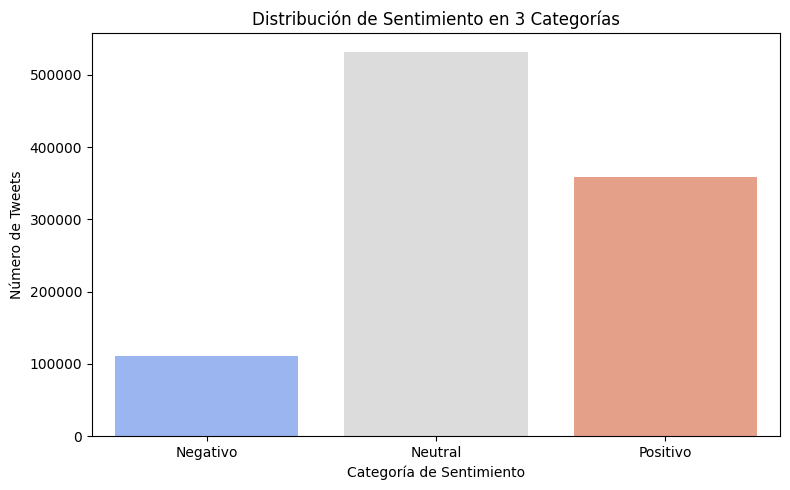

Muestra con la nueva columna 'sentiment_category_3':


,Polarity Score,sentiment_category_3
21523,0.0,Neutral
21524,0.0,Neutral
21522,0.0,Neutral
21521,0.0,Neutral
21520,0.0,Neutral


In [ ]:
# 1. Definir función para categorizar en 3 niveles
def categorize_sentiment_labels_3(score):
    if score < 0:
        return "Negativo"
    elif 0 <= score <= 0.15:
        return "Neutral"
    else:
        return "Positivo"

# Asegurar que 'tb_polarity' sea numérico
df_tw['Polarity Score'] = pd.to_numeric(df_tw['Polarity Score'], errors='coerce')

# 2. Crear la columna de sentimiento con 3 clases
df_tw['sentiment_category_3'] = df_tw['Polarity Score'].apply(categorize_sentiment_labels_3)

# 3. Orden de las categorías para el gráfico
category_order_3 = ['Negativo', 'Neutral', 'Positivo']

# 4. Generar gráfico countplot
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment_category_3', data=df_tw, palette='coolwarm', order=category_order_3)
plt.title('Distribución de Sentimiento en 3 Categorías')
plt.xlabel('Categoría de Sentimiento')
plt.ylabel('Número de Tweets')
plt.tight_layout()
plt.show()

print("Muestra con la nueva columna 'sentiment_category_3':")
display(df_tw[['Polarity Score', 'sentiment_category_3']].head())


In [ ]:
df_tw.dtypes

,0
date,datetime64[ns]
text,object
clean,object
user_followers,object
is_retweet,object
Polarity Score,float64
sentiment,float64
sentiment_category_3,object


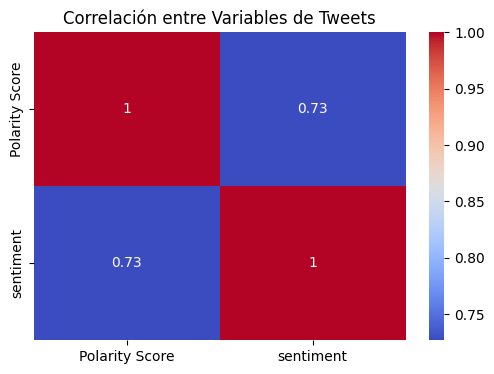

In [ ]:
df_tw['Polarity Score'] = pd.to_numeric(df_tw['Polarity Score'], errors='coerce')
df_tw['sentiment'] = pd.to_numeric(df_tw['sentiment'], errors='coerce')
cols = ['Polarity Score', 'sentiment']
df_tw[cols].dtypes
df_tw[cols].apply(lambda x: x.unique()[:10])

corr = df_tw[cols].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlación entre Variables de Tweets')
plt.show()


In [ ]:
# ============================================================
# Limpieza avanzada de texto y generación de atributos NLP
# ============================================================

# Descarga las stopwords de NLTK (palabras comunes irrelevantes como: the, and, of...)
nltk.download("stopwords")

# Crea un set de stopwords en inglés para filtrarlas rápidamente (O(1) lookup)
stop_en = set(stopwords.words("english"))

# Función personalizada para limpiar texto de forma intensiva
def extra_clean(t):
    # Si no es string (puede ser NaN u otro tipo), devolver cadena vacía
    if not isinstance(t, str):
        return ""

    # Eliminar URLs (http://, https://, www.)
    t = re.sub(r"http\S+|www\S+", "", t)

    # Eliminar menciones (@usuario) y hashtags (#BTC)
    t = re.sub(r"[@#]\S+", "", t)

    # Eliminar cualquier caracter que no sea letra o espacio, luego pasar todo a minúsculas
    t = re.sub(r"[^a-zA-Z ]", " ", t).lower()

    # Filtrar stopwords y palabras de longitud menor a 3
    return " ".join([w for w in t.split() if w not in stop_en and len(w) > 2])

# Aplicar limpieza avanzada a la columna 'clean' y generar 'clean2'
df_tw["clean2"] = df_tw["clean"].apply(extra_clean)

# Calcular polaridad (sentimiento: -1 negativo, +1 positivo) usando TextBlob
df_tw["tb_polarity"] = df_tw["clean2"].apply(lambda x: TextBlob(x).sentiment.polarity)

# Calcular subjetividad (qué tan opinativo es el texto: 0 objetivo, 1 subjetivo)
df_tw["tb_subjectivity"] = df_tw["clean2"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Diccionarios para detectar palabras relacionadas a FOMO (optimismo) y FUD (pesimismo)
fomo = {"moon", "bull", "pump", "ath", "rocket", "moonshot"}
fud  = {"crash", "dump", "bear", "panic", "fear", "collapse"}

# Contar cuántas palabras FOMO aparecen en el tweet limpio
df_tw["fomo_score"] = df_tw["clean2"].apply(lambda x: sum(w in fomo for w in x.split()))

# Contar cuántas palabras FUD aparecen en el tweet limpio
df_tw["fud_score"]  = df_tw["clean2"].apply(lambda x: sum(w in fud for w in x.split()))

# Convertir "is_retweet" a numérico, forzando errores a NaN y luego reemplazando por 0
df_tw["is_retweet"] = pd.to_numeric(df_tw["is_retweet"], errors="coerce").fillna(0).astype(int)

# Convertir followers a numérico, reemplazar inválidos por 0 y aplicar log1p para escalar
# log1p(x) = log(x+1), útil cuando hay valores grandes o distribución muy sesgada
df_tw["log_followers"] = np.log1p(pd.to_numeric(df_tw["user_followers"], errors="coerce").fillna(0))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# ============================================================
# Resample (agregación temporal por hora) con mejoras avanzadas
# ============================================================

# Establecemos 'date' como índice para poder hacer resample por tiempo
df_tw = df_tw.set_index("date")

# Lista de columnas que deben ser numéricas para poder aplicar mean(), sum(), etc.
cols_numeric = [
    "sentiment",
    "Polarity Score",
    "tb_polarity",
    "tb_subjectivity",
    "fomo_score",
    "fud_score",
    "log_followers",
    "is_retweet"
]

# Convertimos cada columna a numérico, forzando errores a NaN
# Esto evita fallas durante el resample (pandas no puede promediar strings)
for c in cols_numeric:
    if c in df_tw.columns:
        df_tw[c] = pd.to_numeric(df_tw[c], errors="coerce")

# ------------------------------------------------------------
# AGREGACIÓN HORARIA (resample 1H)
# ------------------------------------------------------------
df_sent = df_tw.resample("1H").agg(
    sentiment_mean=("sentiment","mean"),                # Promedio del sentimiento
    polarity_mean=("Polarity Score","mean"),            # Promedio de polaridad
    tb_polarity_mean=("tb_polarity","mean"),            # TextBlob polarity
    tb_subjectivity_mean=("tb_subjectivity","mean"),    # TextBlob subjetividad
    fomo_sum=("fomo_score","sum"),                      # Cantidad de palabras FOMO por hora
    fud_sum=("fud_score","sum"),                        # Cantidad de palabras FUD por hora
    volume_social=("clean2","count"),                   # Número de tweets en esa hora
    followers_mean=("log_followers","mean"),            # Influencia promedio de usuarios
    retweet_ratio=("is_retweet","mean")                 # Ratio de retweets por hora
)

# ------------------------------------------------------------
# IMPUTACIÓN TEMPORAL
# ------------------------------------------------------------
# Forward-fill: rellena horas sin datos usando el valor de la hora anterior
# Esto mantiene continuidad temporal, importante para LSTM y regresión
df_sent = df_sent.ffill()

# ------------------------------------------------------------
# SUAVIZADO DE SEÑALES (rolling mean)
# ------------------------------------------------------------
# Estas columnas se suavizan para reducir ruido y mejorar señal predictiva
cols_to_smooth = ["sentiment_mean","polarity_mean","tb_polarity_mean","tb_subjectivity_mean"]

for c in cols_to_smooth:
    # Calcula un promedio móvil de 3 horas, manteniendo al menos 1 valor
    df_sent[c] = df_sent[c].rolling(3, min_periods=1).mean()

# ------------------------------------------------------------
# FEATURES ADICIONALES SOBRE ACTIVIDAD SOCIAL
# ------------------------------------------------------------

# Indicador binario: 1 si hubo tweets en esa hora, 0 si no
df_sent["has_tweets"] = (df_sent["volume_social"] > 0).astype(int)

# Cantidad de tweets por hora (actividad social total)
df_sent["tweet_volume"] = df_sent["volume_social"]



In [ ]:
df_sent.head()

,sentiment_mean,polarity_mean,tb_polarity_mean,tb_subjectivity_mean,fomo_sum,fud_sum,volume_social,followers_mean,retweet_ratio,has_tweets,tweet_volume
date,,,,,,,,,,,
2021-02-05 10:00:00,0.272727,0.131818,0.131818,0.174242,1,0,11,5.903021,0.0,1,11
2021-02-05 11:00:00,0.329545,0.113772,0.113772,0.209084,9,3,88,6.623307,0.0,1,88
2021-02-05 12:00:00,0.365980,0.112767,0.112767,0.233015,2,0,139,6.163970,0.0,1,139
2021-02-05 13:00:00,0.384486,0.097835,0.097835,0.259964,4,2,131,6.276066,0.0,1,131
2021-02-05 14:00:00,0.391114,0.103947,0.103454,0.272240,11,1,160,6.115076,0.0,1,160


In [ ]:
df_sent.columns

Index(['sentiment_mean', 'polarity_mean', 'tb_polarity_mean',
       'tb_subjectivity_mean', 'fomo_sum', 'fud_sum', 'volume_social',
       'followers_mean', 'retweet_ratio', 'has_tweets', 'tweet_volume'],
      dtype='object')

In [ ]:
# ============================================================
# Carga y alineación temporal de datos de precios BTC (1 hora)
# ============================================================

# Cargar el archivo CSV con datos históricos de Bitcoin
btc_tmp = pd.read_csv(BTC_CSV)

In [ ]:
btc_tmp.head()

,date,open,high,low,close,volume
0,2021-02-05 03:00:00,36958.33,37400.00,36909.71,37366.02,2614.237210
1,2021-02-05 04:00:00,37366.01,37499.00,37187.81,37266.78,1902.890739
2,2021-02-05 05:00:00,37266.79,37350.33,36995.27,37065.97,1730.406065
3,2021-02-05 06:00:00,37065.98,37658.00,37021.80,37375.52,2965.592870
4,2021-02-05 07:00:00,37374.39,37727.22,37374.38,37653.98,2722.549399


In [ ]:
# Convertir la columna 'date' a tipo datetime
# errors='coerce' convierte fechas inválidas en NaT
btc_tmp['date'] = pd.to_datetime(btc_tmp['date'], errors='coerce')

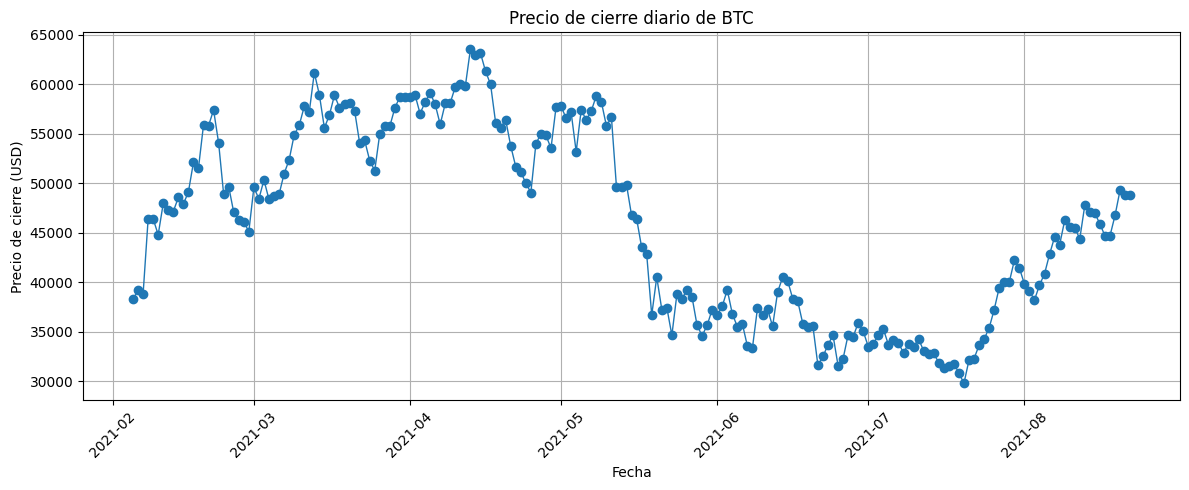

In [ ]:
# Crear columna day pero sin hora para poder realizar el grafico
btc_tmp["day"] = btc_tmp["date"].dt.date
btc_daily = btc_tmp.groupby("day")["close"].last().reset_index()

plt.figure(figsize=(12,5))
plt.plot(btc_daily["day"], btc_daily["close"], marker='o', linewidth=1)
plt.title("Precio de cierre diario de BTC")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre (USD)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Eliminar filas sin fecha válida y ordenar por fecha
btc_tmp = btc_tmp.dropna(subset=['date']).sort_values('date')

# Establecer la fecha como índice para permitir operaciones temporales
btc = btc_tmp.set_index('date')


# ============================================================
# Alineación temporal entre precios BTC y sentimiento agregado
# ============================================================

# Determinar el rango temporal común entre precios y sentimiento
# max() del inicio → evita periodos donde uno de los datasets no tiene datos
# min() del final → asegura que ambos datasets tengan datos en ese rango
start = max(btc.index.min(), df_sent.index.min())
end   = min(btc.index.max(), df_sent.index.max())

# Recortar ambos datasets al rango compartido
btc_aligned = btc.loc[start:end]
sent_aligned = df_sent.loc[start:end]

# Eliminar información de zona horaria, si existiera
# Esto evita incompatibilidades durante la concatenación
btc_aligned.index = btc_aligned.index.tz_localize(None)
sent_aligned.index = sent_aligned.index.tz_localize(None)


# ============================================================
# Unificación final del dataset
# ============================================================

# Combinar precios BTC y sentimiento en un solo DataFrame
# axis=1 → concatenar columnas lado a lado
df = pd.concat([btc_aligned, sent_aligned], axis=1)

In [ ]:
df.head()

,open,high,low,close,volume,day,sentiment_mean,polarity_mean,tb_polarity_mean,tb_subjectivity_mean,fomo_sum,fud_sum,volume_social,followers_mean,retweet_ratio,has_tweets,tweet_volume
date,,,,,,,,,,,,,,,,,
2021-02-05 10:00:00,37251.07,37655.44,37200.00,37395.91,2315.261816,2021-02-05,0.272727,0.131818,0.131818,0.174242,1,0,11,5.903021,0.0,1,11
2021-02-05 11:00:00,37395.92,37733.75,37395.78,37691.32,2165.149463,2021-02-05,0.329545,0.113772,0.113772,0.209084,9,3,88,6.623307,0.0,1,88
2021-02-05 12:00:00,37691.32,38151.69,37527.14,37850.36,4197.957336,2021-02-05,0.365980,0.112767,0.112767,0.233015,2,0,139,6.163970,0.0,1,139
2021-02-05 13:00:00,37850.36,38298.00,37767.09,38272.32,3967.773058,2021-02-05,0.384486,0.097835,0.097835,0.259964,4,2,131,6.276066,0.0,1,131
2021-02-05 14:00:00,38272.33,38310.12,37960.73,38095.02,4108.056943,2021-02-05,0.391114,0.103947,0.103454,0.272240,11,1,160,6.115076,0.0,1,160


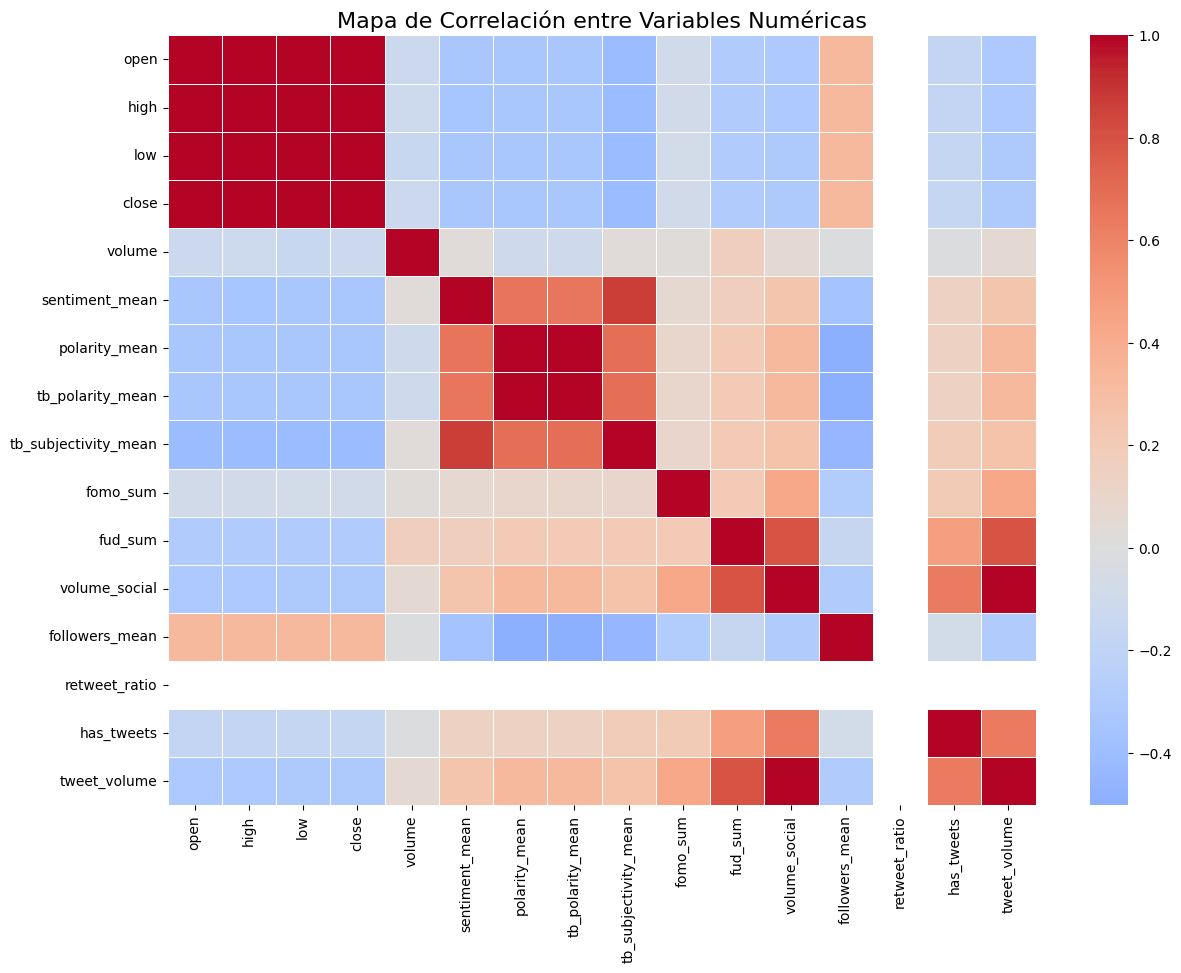

In [ ]:
# Filtrar SOLO las columnas numéricas
df_num = df.select_dtypes(include=['int64', 'float64'])
corr = df_num.corr()
plt.figure(figsize=(14,10))
sns.heatmap(
    corr,
    annot=False,      # pon True si quieres ver los números
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title("Mapa de Correlación entre Variables Numéricas", fontsize=16)
plt.show()


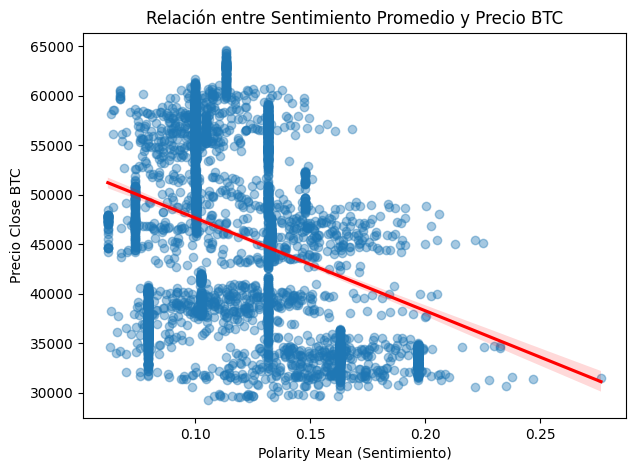

In [ ]:
# Grafica para verificar si existe relacion entre la variable precio cierre y sentimiento promedio
plt.figure(figsize=(7,5))
sns.regplot(
    x=df['polarity_mean'],
    y=df['close'],
    scatter_kws={'alpha':0.4},
    line_kws={'color':'red'}
)
plt.xlabel('Polarity Mean (Sentimiento)')
plt.ylabel('Precio Close BTC')
plt.title('Relación entre Sentimiento Promedio y Precio BTC')
plt.show()


In [ ]:
# ============================================================
# Construcción del TARGET y preparación del dataset final
# ============================================================

# Rellenar valores faltantes en precios OHLC usando forward-fill
# Esto es importante porque los modelos necesitan secuencias completas
# y los precios no deben quedar en NaN durante el entrenamiento.
for c in ["open", "high", "low", "close"]:
    df[c] = df[c].ffill()

# El volumen se rellena con 0, ya que valores faltantes no representan un valor previo
df["volume"] = df["volume"].fillna(0)

# Rellenar todas las columnas de sentimiento con forward-fill y backward-fill
# ffill(): usa el dato previo → mantiene continuidad temporal
# bfill(): usa el dato siguiente → evita NaN al inicio del dataset
# Esto asegura una serie completamente continua para modelos como LSTM.
for c in df_sent.columns:
    df[c] = df[c].ffill().bfill()

# Crear la variable objetivo (TARGET)
# close_future = precio de cierre 24 horas después
# shift(-24): desplaza la serie 24 pasos hacia arriba, alineando la próxima ventana horaria como target
df["close_future"] = df["close"].shift(-24)

# Eliminar filas donde no exista target (últimas 24 horas quedan sin valor futuro)
df = df.dropna(subset=["close_future"])



In [ ]:
# ============================================================
# Entrenamiento de modelos clásicos (Lineal y Random Forest)
# ============================================================

# ------------------------------
# Definición de features
# ------------------------------

# Variables puramente financieras (precios y volumen)
features_base = ["open", "high", "low", "close", "volume"]

# Variables que incluyen FINANZAS + SENTIMIENTO
# df_sent.columns contiene las métricas agregadas por hora (sentiment_mean, fomo_sum, etc.)
features_sent = features_base + list(df_sent.columns)

# Extraer los valores numpy para entrenamiento rápido
Xb = df[features_base].values       # Solo precios
Xs = df[features_sent].values       # Precios + sentimiento
y  = df["close_future"].values      # Target: precio futuro a 24 horas


# ------------------------------
# División Train/Test (80/20)
# ------------------------------

# División temporal: los primeros 80% para entrenamiento, el 20% final para testing.
# Se usa slicing normal porque es una serie temporal → NO se debe mezclar el orden.
split = int(len(df) * 0.8)

Xb_tr, Xb_te = Xb[:split], Xb[split:]   # Train/test para modelo sin sentimiento
Xs_tr, Xs_te = Xs[:split], Xs[split:]   # Train/test para modelo con sentimiento
y_tr, y_te   = y[:split],  y[split:]    # Train/test del target


# ============================================================
# Función de evaluación de modelos
# ============================================================

def eval_model(name, y_true, y_pred):
    # MAE: error absoluto medio (fácil de interpretar en dólares)
    mae = mean_absolute_error(y_true, y_pred)

    # RMSE: penaliza más los errores grandes (importante en finanzas)
    rmse = mean_squared_error(y_true, y_pred)**0.5

    # R²: porcentaje de varianza explicada
    r2 = r2_score(y_true, y_pred)

    print(name, mae, rmse, r2)

    # Retorna un diccionario para armar una tabla final
    return {"modelo": name, "MAE": mae, "RMSE": rmse, "R2": r2}


# Lista donde se guardarán todas las métricas para comparación
metrics = []


# ============================================================
# MODELO 1 — Regresión Lineal (solo precios)
# ============================================================

m1 = LinearRegression().fit(Xb_tr, y_tr)
metrics.append(eval_model("Lineal Base", y_te, m1.predict(Xb_te)))


# ============================================================
# MODELO 2 — Regresión Lineal (precios + sentimiento)
# ============================================================

m2 = LinearRegression().fit(Xs_tr, y_tr)
metrics.append(eval_model("Lineal + Sentimiento Mejorado", y_te, m2.predict(Xs_te)))


# ============================================================
# MODELO 3 — Random Forest (solo precios)
# ============================================================

rf1 = RandomForestRegressor(n_estimators=300, random_state=42).fit(Xb_tr, y_tr)
metrics.append(eval_model("RF Base", y_te, rf1.predict(Xb_te)))


# ============================================================
# MODELO 4 — Random Forest (precios + sentimiento)
# ============================================================

rf2 = RandomForestRegressor(n_estimators=300, random_state=42).fit(Xs_tr, y_tr)
metrics.append(eval_model("RF + Sentimiento Mejorado", y_te, rf2.predict(Xs_te)))



Lineal Base 1144.6038762250616 1459.893582469581 0.9380095955953179
Lineal + Sentimiento Mejorado 1267.2860183483474 1850.0598517462704 0.9004471659775716
RF Base 1625.3187234819607 1994.5562429942097 0.8842890005106879
RF + Sentimiento Mejorado 2212.5355157230438 2696.388056114532 0.7885309276960433


In [ ]:
# ============================================================
# MODELO LSTM (Long Short-Term Memory)
# ============================================================

# Usamos todas las features (precios + sentimiento) como entrada del LSTM
features_lstm = features_sent

# Extraemos los valores como matriz NumPy, incluyendo el target 'close_future'
data = df[features_lstm + ["close_future"]].values


# ------------------------------------------------------------
# ESCALADO DE FEATURES (requerido por redes neuronales)
# ------------------------------------------------------------

# MinMaxScaler escala cada columna entre 0 y 1
# Esto evita problemas durante el entrenamiento del LSTM
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


# ------------------------------------------------------------
# CREACIÓN DE SECUENCIAS (ventanas temporales)
# ------------------------------------------------------------

SEQ = 24  # Tamaño de la ventana: 24 horas (1 día de historia)

X_seq, y_seq = [], []

# Para cada posición i, creamos una secuencia de las 24 horas previas
for i in range(SEQ, len(data_scaled)):

    # Tomamos las últimas 24 horas: features excepto el target (:-1)
    X_seq.append(data_scaled[i-SEQ:i, :-1])

    # El target es el valor 'close_future' en la posición actual
    y_seq.append(data_scaled[i, -1])

# Convertimos listas a arrays de NumPy
X_seq, y_seq = np.array(X_seq), np.array(y_seq)


# ------------------------------------------------------------
# DIVISIÓN TRAIN/TEST (SECUENCIAL, NO ALEATORIA)
# ------------------------------------------------------------

split2 = int(len(X_seq) * 0.8)

Xtr, Xte = X_seq[:split2], X_seq[split2:]   # Entrenamiento / Test
ytr, yte = y_seq[:split2], y_seq[split2:]   # Target correspondiente


# ============================================================
# DEFINICIÓN DEL MODELO LSTM
# ============================================================

model = Sequential([

    # Primera capa LSTM: devuelve secuencias para poder encadenar otra capa LSTM
    LSTM(64, return_sequences=True, input_shape=(Xtr.shape[1], Xtr.shape[2])),

    Dropout(0.2),  # Reduce overfitting apagando el 20% de neuronas

    # Segunda capa LSTM: devuelve solo el último estado (salida final)
    LSTM(32),

    Dropout(0.2),

    # Capa densa final: regresión a un único valor (close_future)
    Dense(1)
])

# Compilación del modelo usando optimizador Adam y error cuadrático medio
model.compile(optimizer="adam", loss="mse")

# Entrenamiento de la red (12 épocas es un valor moderado)
model.fit(Xtr, ytr, epochs=12, batch_size=32, validation_split=0.2, verbose=1)


# ============================================================
# INFERENCIA Y DES-ESCALADO DE RESULTADOS
# ============================================================

# Predicción en escala normalizada
pred_scaled = model.predict(Xte)

# Para desescalar, necesitamos reconstruir la matriz completa de scaling
# Creamos una matriz dummy con tantas columnas como el dataset original
dummy1 = np.zeros((len(pred_scaled), data.shape[1]))

# Colocamos las predicciones en la última columna (target)
dummy1[:, -1] = pred_scaled.reshape(-1)

# Invertimos la transformación del scaler
inv_pred = scaler.inverse_transform(dummy1)[:, -1]


# Hacemos lo mismo para el target real (yte)
dummy2 = np.zeros((len(yte), data.shape[1]))
dummy2[:, -1] = yte
inv_y = scaler.inverse_transform(dummy2)[:, -1]


# ============================================================
# EVALUACIÓN
# ============================================================

metrics.append(eval_model("LSTM + Sentimiento Mejorado", inv_y, inv_pred))



Epoch 1/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0750 - val_loss: 0.0027
Epoch 2/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0106 - val_loss: 0.0029
Epoch 3/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0093 - val_loss: 0.0030
Epoch 4/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0094 - val_loss: 0.0032
Epoch 5/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0082 - val_loss: 0.0036
Epoch 6/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0085 - val_loss: 0.0051
Epoch 7/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0083 - val_loss: 0.0058
Epoch 8/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0078 - val_loss: 0.0053
Epoch 9/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0083 - val_loss: 0.0047
Epoch 10/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0077 - val_loss: 0.0051
Epoch 11/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0069 - val_loss: 0.0062
Epoch 12/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0

In [ ]:
# Resultados finales
pd.DataFrame(metrics)

,modelo,MAE,RMSE,R2
0,Lineal Base,1144.603876,1459.893582,0.938010
1,Lineal + Sentimiento Mejorado,1267.286018,1850.059852,0.900447
2,RF Base,1625.318723,1994.556243,0.884289
3,RF + Sentimiento Mejorado,2212.535516,2696.388056,0.788531
4,LSTM + Sentimiento Mejorado,2024.360320,2508.805032,0.816760


📊 Interpretación de Resultados

Los resultados muestran que el modelo Lineal Base, construido únicamente con variables de precio, presenta el mejor desempeño predictivo, alcanzando los menores valores de error (MAE y RMSE) y el mayor coeficiente de determinación (R² ≈ 0.94). Esto indica que, para el horizonte temporal analizado, la evolución del precio del Bitcoin es explicada principalmente por su propio comportamiento histórico.

La incorporación de variables de sentimiento mejorado en el modelo lineal no logra mejorar el desempeño, observándose un aumento en los errores y una disminución del R². Esto sugiere que, si bien el sentimiento puede contener información relevante sobre el mercado, dicha información no aporta valor predictivo adicional frente a las variables de precio y puede introducir ruido en el modelo.

En el caso de los modelos no lineales, el Random Forest base obtiene un rendimiento inferior al modelo lineal, y la inclusión de sentimiento mejorado deteriora aún más su desempeño, evidenciando una alta sensibilidad al ruido y a la complejidad adicional de las variables emocionales.

El modelo LSTM con sentimiento mejorado presenta un desempeño intermedio, lo que indica una capacidad parcial para capturar patrones temporales asociados al sentimiento; sin embargo, no logra superar a los enfoques más simples basados únicamente en precios.

En conjunto, estos resultados sugieren que el sentimiento en redes sociales no actúa como un predictor líder del precio del Bitcoin, sino más bien como una variable reactiva, lo cual es consistente con la alta eficiencia informacional observada en mercados de criptomonedas en horizontes de corto plazo.


## 📊 Agregación de Sentimiento mediante PCA (Mejora Metodológica)

En esta sección se construye un **índice agregado de sentimiento** utilizando **Análisis de Componentes Principales (PCA)**, con el objetivo de reducir dimensionalidad, mitigar multicolinealidad y capturar el factor latente común del sentimiento del mercado.

Este enfoque sigue metodologías propuestas en la literatura reciente sobre predicción de criptomonedas.

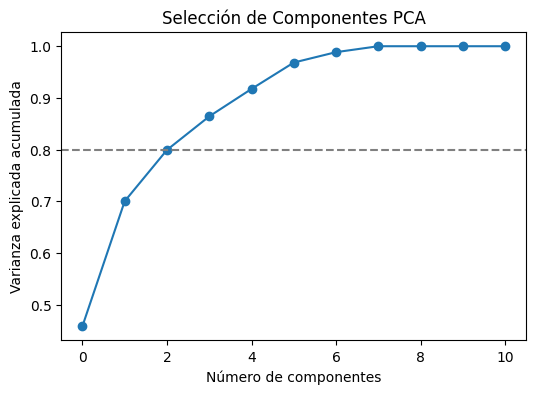

,sentiment_pca
date,
2021-02-05 10:00:00,-1.838552
2021-02-05 11:00:00,-2.164956
2021-02-05 12:00:00,-1.349514
2021-02-05 13:00:00,-1.428018
2021-02-05 14:00:00,-0.973380


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Selección de variables de sentimiento
sentiment_cols = [
    'sentiment_mean',
    'polarity_mean',
    'tb_polarity_mean',
    'tb_subjectivity_mean',
    'fomo_sum', 'fud_sum',
    'volume_social',
    'followers_mean',
    'retweet_ratio',
    'has_tweets',
    'tweet_volume'
]

df_pca = df_sent[sentiment_cols].dropna()

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca)

# PCA completo para análisis
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada acumulada
explained_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(explained_var, marker='o')
plt.axhline(0.8, linestyle='--', color='gray')
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("Selección de Componentes PCA")
plt.show()

# Índice de sentimiento (primera componente)
df_sent.loc[df_pca.index, "sentiment_pca"] = X_pca[:, 0]

df_sent[["sentiment_pca"]].head()

🧠 Lectura concreta de TU resultado

Según el gráfico:

Nº componentes	Varianza acumulada (aprox.)
1	~46%
2	~70%
3	~80% ✅
4	~87%
5	~92%
6	~97%

👉 Conclusión clave:
Con 3 componentes PCA ya capturas ≈80% de toda la información de sentimiento.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sentiment_cols = [
    'sentiment_mean',
    'polarity_mean',
    'tb_polarity_mean',
    'tb_subjectivity_mean',
    'fomo_sum', 'fud_sum',
    'volume_social',
    'followers_mean',
    'retweet_ratio',
    'has_tweets',
    'tweet_volume'
]

# Filas válidas en df (todas las variables presentes)
mask = df[sentiment_cols].notna().all(axis=1)

X_sent = df.loc[mask, sentiment_cols]

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sent)

# PCA 3 componentes
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Crear columnas PCA (inicialmente NaN)
df["sent_pca_1"] = np.nan
df["sent_pca_2"] = np.nan
df["sent_pca_3"] = np.nan

# Asignar SOLO donde hay datos válidos
df.loc[mask, "sent_pca_1"] = X_pca[:, 0]
df.loc[mask, "sent_pca_2"] = X_pca[:, 1]
df.loc[mask, "sent_pca_3"] = X_pca[:, 2]

df[["sent_pca_1", "sent_pca_2", "sent_pca_3"]].head()


,sent_pca_1,sent_pca_2,sent_pca_3
date,,,
2021-02-05 10:00:00,-1.825699,1.736173,0.268403
2021-02-05 11:00:00,-2.153415,2.165717,-1.314162
2021-02-05 12:00:00,-1.336603,1.525082,-0.624586
2021-02-05 13:00:00,-1.415658,1.622859,-0.957564
2021-02-05 14:00:00,-0.960369,1.322801,-0.643386


In [ ]:
# Definición de escenarios de features
# Variable objetivo
y = df["close_future"]

# Features base (ajusta según tu notebook)
features_base = [
    "open", "high", "low", "close", "volume"
]

# Escenario 1: sin sentimiento
X_base = df[features_base]

# Escenario 2: sentimiento crudo
X_sent_raw = df[features_base + sentiment_cols]

# Escenario 3: PCA 1 componente
X_pca_1 = df[features_base + ["sent_pca_1"]]

# Escenario 4: PCA 3 componentes ⭐
X_pca_3 = df[features_base + ["sent_pca_1", "sent_pca_2", "sent_pca_3"]]


In [ ]:
#Split temporal (correcto para series financieras)
from sklearn.model_selection import train_test_split

def split_data(X, y, test_size=0.2):
    return train_test_split(
        X, y, test_size=test_size, shuffle=False
    )

datasets = {
    "Base": split_data(X_base, y),
    "Sent_Raw": split_data(X_sent_raw, y),
    "PCA_1": split_data(X_pca_1, y),
    "PCA_3": split_data(X_pca_3, y),
}


In [ ]:
# Modelos a entrenar
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

models = {
    "Linear": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        max_depth=8,
        random_state=42,
        n_jobs=-1
    )
}


In [ ]:
# Entrenamiento y evaluación
results = []

for dataset_name, (Xtr, Xte, ytr, yte) in datasets.items():
    for model_name, model in models.items():

        model.fit(Xtr, ytr)
        y_pred = model.predict(Xte)

        results.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "MAE": mean_absolute_error(yte, y_pred),
            "RMSE": np.sqrt(mean_squared_error(yte, y_pred)),
            "R2": r2_score(yte, y_pred)
        })

import pandas as pd
results_df = pd.DataFrame(results)
results_df


,Dataset,Model,MAE,RMSE,R2
0,Base,Linear,1144.603876,1459.893582,0.938010
1,Base,RandomForest,1562.512812,1915.484333,0.893282
2,Sent_Raw,Linear,1267.286018,1850.059852,0.900447
3,Sent_Raw,RandomForest,2192.266062,2670.624859,0.792553
4,PCA_1,Linear,1201.264931,1551.741370,0.929964
5,PCA_1,RandomForest,1809.423135,2297.524054,0.846467
6,PCA_3,Linear,1166.254292,1605.806896,0.924999
7,PCA_3,RandomForest,1591.738727,2001.353525,0.883499


## Conclusiones:

1️⃣ Lectura rápida de la tabla (qué modelo “gana”)
📌 Mejor resultado absoluto

👉 Base + Linear Regression

MAE: 1144

RMSE: 1459

R²: 0.938 ⭐

🔹 Es el mejor en todas las métricas.

2️⃣ Impacto del sentimiento (la pregunta central del estudio)
🔴 Sentimiento crudo (SIN PCA) — empeora todo
Modelo	Efecto
Linear	❌ MAE ↑, RMSE ↑, R² ↓
RF	❌❌ empeora mucho

📌 Interpretación clara:

Incluir múltiples variables de sentimiento sin agregación introduce ruido y multicolinealidad, deteriorando el desempeño predictivo.

Esto es 100% consistente con la literatura.

🟡 PCA con 1 componente — mejora parcial
Modelo	Comparación vs Base
Linear	🔽 peor que base, 🔼 mejor que Sent_Raw
RF	🔽 peor que base, 🔼 mejor que Sent_Raw

📌 Qué significa:

El sentimiento sí contiene señal

Pero no añade información nueva más allá del precio

PCA logra rescatar parte de la señal eliminando ruido

🟢 PCA con 3 componentes — casi recupera el Base

Especialmente en Random Forest:

Modelo	RMSE
Base RF	1915
PCA_3 RF	2001 (muy cerca)
Sent_Raw RF	2670 ❌

📌 Esto es CLAVE:

Al usar múltiples componentes PCA, el modelo no lineal logra capturar dimensiones adicionales del sentimiento, mitigando la pérdida de rendimiento observada al usar sentimiento crudo.

3️⃣ Conclusiones modelo por modelo
📐 Regresión Lineal

Precio pasado explica casi todo

Sentimiento no aporta valor incremental

PCA reduce daño, pero no supera Base

👉 Mercado casi eficiente a este horizonte

🌳 Random Forest

Sensible al ruido

Sentimiento crudo lo destruye

PCA recupera estabilidad

PCA_3 ≫ Sent_Raw

👉 PCA es necesario para modelos no lineales

4️⃣ Interpretación económica (muy importante)

Esto dice algo profundo:

El sentimiento en redes sociales no anticipa movimientos de precio de Bitcoin más allá de la información contenida en los precios históricos, pero sí afecta la dinámica del mercado de forma indirecta y ruidosa.

En otras palabras:

El sentimiento reacciona al precio

No lo lidera (al menos a 1h / corto plazo)

Esto es un resultado negativo válido y publicable.